# Return Forecasting: Read Historical Daily Yen Futures Data

## Initial Imports

In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

### Data Preparation

In [30]:
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


#### Triming the dataset to begin on January 1st, 1990

In [31]:
yen_futures = yen_futures.loc["1990-01-01":,:]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


### Return Forecasting: Initial Time-Series Plotting

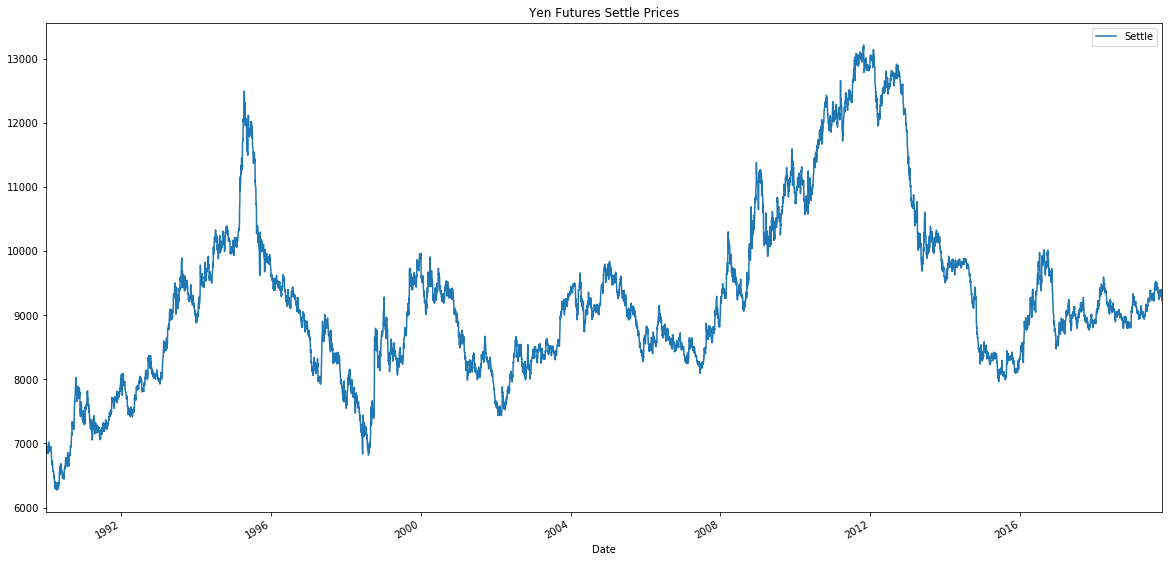

In [32]:
yen_futures.Settle.plot(figsize=(20,10),title="Yen Futures Settle Prices",legend=True)

### Decomposition Using a Hodrick-Prescott Filter
#### Initial Imports and Data Preparation

In [33]:
import statsmodels.api as sm
ts_noise,ts_trend=sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [34]:
settle_price = pd.DataFrame()
settle_price= yen_futures[["Settle"]].copy()
settle_price["trend"]=ts_trend
settle_price["noise"]=ts_noise
settle_price.head()

,Settle,trend,noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


#### Plotting the Settle Price vs. the Trend for 2015 to the present

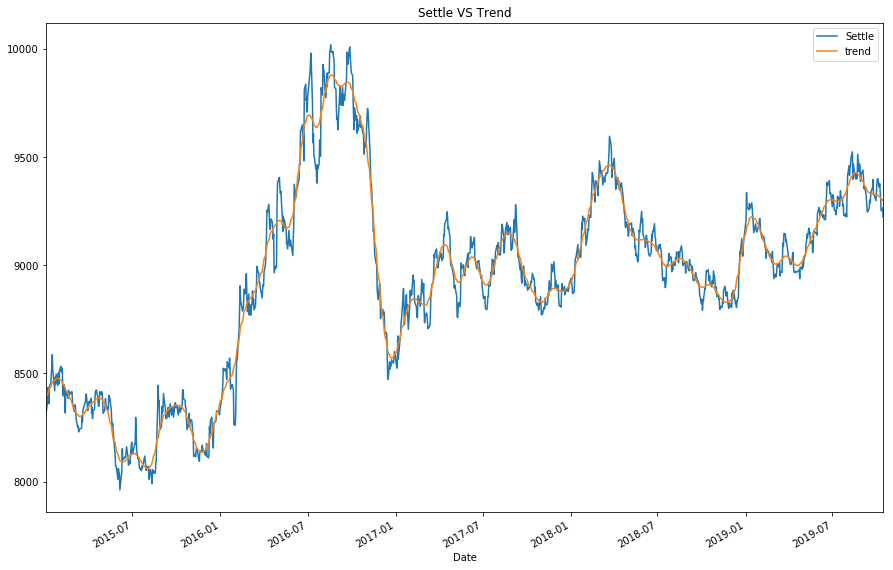

In [35]:
settle_price.loc["2015-01-01":].plot(y=["Settle","trend"],legend=True,title="Settle VS Trend",figsize=(15,10))

#### Plotting the Settle Noise

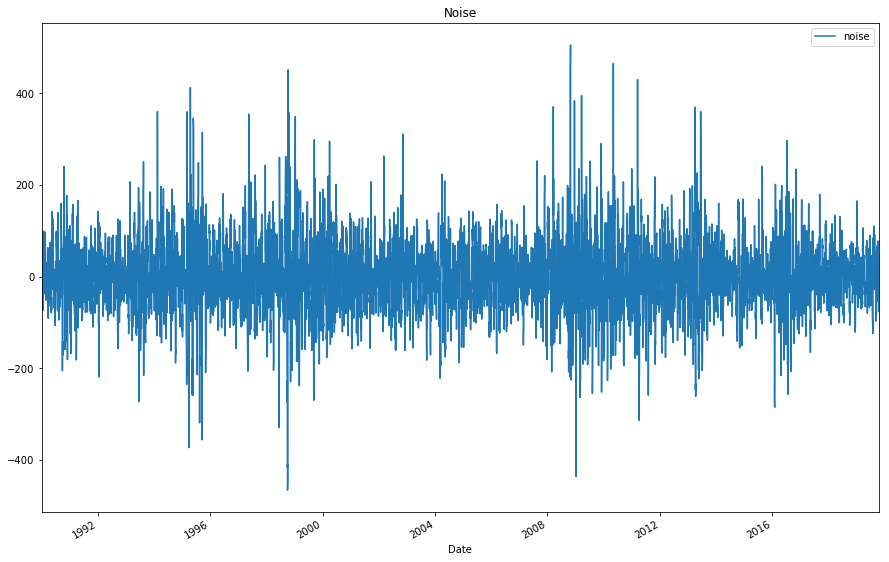

In [36]:
settle_price.noise.plot(legend=True,title="Noise",figsize=(15,10))

###  Forecasting Returns using an ARMA Model

#### Initial Imports and Data Preparation

In [37]:
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings("ignore")

In [38]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


#### Running ARMA

In [39]:
model = ARMA(returns.values,order=(2,1))
results= model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 24 Feb 2021   AIC                          15798.142
Time:                        22:24:50   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3065      1.277     -0.240      0.810      -2.809       2.196
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2949      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3321           +0.0000j            3.3321            0.5000
AR.2         -157.1329           +0.0000j          157.1329            0.5000
MA.1           -3.3908           +0.0000j            3.3908            0.5000
-----------------------------------------------------------------------------
"""

#### Making and Plotting 5 Day Price Forecast

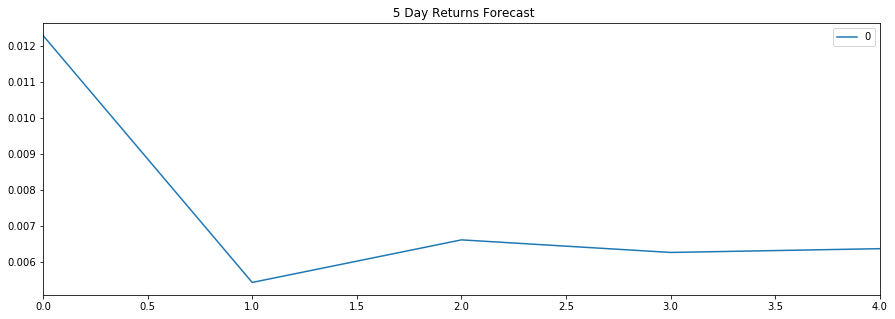

In [40]:
prediction= pd.DataFrame(results.forecast(steps=5)[0])
prediction.plot(title=" 5 Day Returns Forecast", figsize=(15,5))

### Forecasting the Settle Price using an ARIMA Model

#### Initial Imports and Data Preparation

In [41]:
from statsmodels.tsa.arima_model import ARIMA
p=5
d=1
q=1

#### Running ARIMA

In [42]:
model=ARIMA(yen_futures["Settle"],order=(p,d,q))
outcome= model.fit()
outcome.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 24 Feb 2021   AIC                          83905.238
Time:                        22:24:52   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2830      0.698      0.405      0.685      -1.086       1.652
ar.L2.D.Settle     0.0007      0.016      0.044      0.965      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.031      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0136      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.063      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2980      0.698     -0.427      0.670      -1.667       1.071
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8927           -1.3778j            2.3411           -0.1001
AR.2            1.8927           +1.3778j            2.3411            0.1001
AR.3           -2.2739           -3.0183j            3.7790           -0.3528
AR.4           -2.2739           +3.0183j            3.7790            0.3528
AR.5          -11.2031           -0.0000j           11.2031           -0.5000
MA.1            3.3558           +0.0000j            3.3558            0.0000
-----------------------------------------------------------------------------
"""

#### Making and Plotting 5 Day Price Forecast

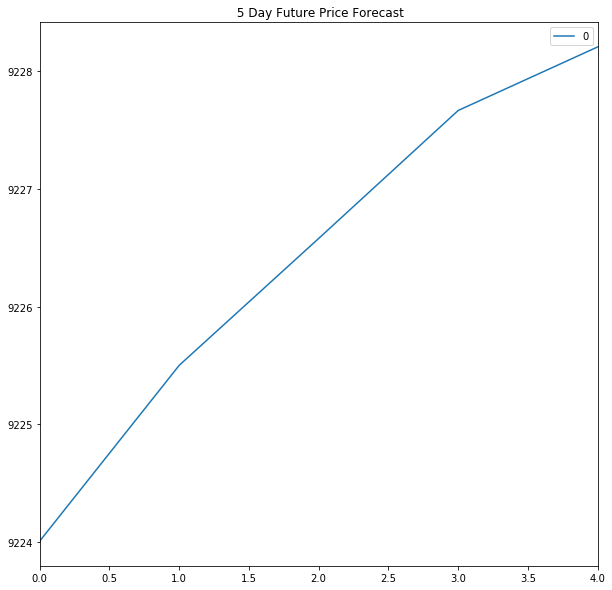

In [43]:
predictions = pd.DataFrame(outcome.forecast(steps=5)[0])
predictions.plot(title=" 5 Day Future Price Forecast", figsize=(10,10))

###  Volatility Forecasting with GARCH

#### Initial Imports

In [44]:
import arch
from arch import arch_model

#### Running GARCH

In [45]:
model = arch_model(returns, mean="Zero",vol="GARCH",p=1,q=1)
results = model.fit(disp="off")
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Wed, Feb 24 2021   Df Residuals:                     7514
Time:                        22:24:54   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

#### Making and Plotting 5 Day Price Forecast

In [46]:
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [47]:
forecast_horizon = 5
forecast = results.forecast(start=last_day,horizon=forecast_horizon)
intermediate = np.sqrt(forecast.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [48]:
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


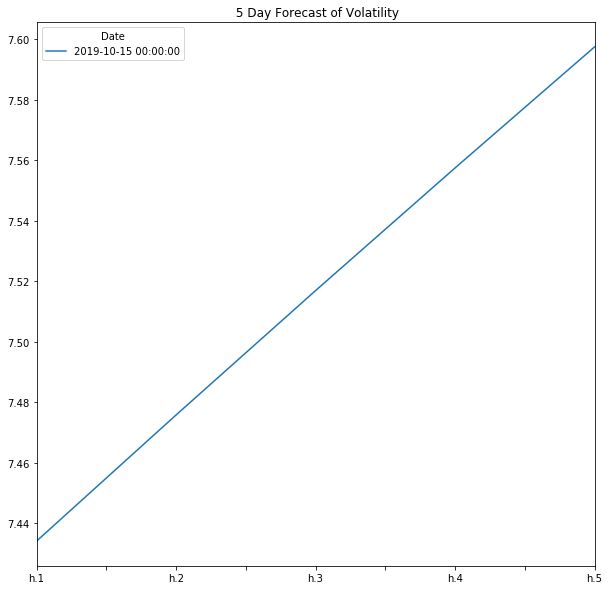

In [49]:
final.plot(title=" 5 Day Forecast of Volatility", figsize=(10,10))

### Conclusion

- As per model, returns on Yen are supposed to decrease and I will not buy Yen at this time. Seeing the volatility, risk of the Yen is expected to increase

- The Models are giving high P-values due to which I dont feel confident in using these models for investment purpose